>**Algoritmos para Big Data**

>**2023/24**

# Exploratory Data Analysis (EDA)
In this lecture, we will carry out some common data analysis to extract insights from data stored in a DataFrame. The main goal is to consolidate knownledge from previous lectures about useful Spark's transformations and actions functions.

# Problem formulation

This exercise is about EDA related to **Fire Department calls for service** in San Francisco, USA. 

We ask you write down a Spark program that:

a) Reads a file containing the dataset under analysis.

b) Provides answers to the following questions about the data.

1. How many distinct types of calls were made to the Fire Department?
2. What are distinct types of calls that were made to the Fire Department?
3. Find out all responses or delayed times that were greater than 5 minutes?
4. What were the most common call types, listed in descending order by count?
5. What zip codes accounted for most common calls and what type were they?
6. What neighbourhoods are in the two top zip codes from the listing in the previous question?

**Dataset**

The dataset of concern, and related information, can be downloaded using the command

>wget bigdata.iscte.me/abd/fire-department-calls.zip


# Initial settings

Prior to any computation, let us set required imports and create a Spark session, 
as well as defining useful functions.

In [1]:
import findspark, pyspark

from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

In [2]:
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Create our Spark session

findspark.init()
findspark.find()

spark = SparkSession\
        .builder\
        .appName("FireDepartmentCalls")\
        .config("spark.sql.shuffle.partitions",6)\
        .config("spark.sql.repl.eagereval.enabled",True)\
        .getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/05 14:29:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

## Useful visualization function

Function relying on Seaborn to plot data but as Python data frame.

See https://seaborn.pydata.org/index.html

We encourage you to use your own plotting functions. Remember: *"A picture is worth a thousand words"*

In [5]:
def plotHorizBar(df, xcol, ycol, colour):
    sns.barplot(data=df, x=xcol, y=ycol, color=colour)

# Data ingestion
Checking source of data and then reading it.

In [ ]:
pwd

In [ ]:
ls -la

In [ ]:
ls -la ../Datasets/fire-department-calls

In [9]:
! head -n 2 "../Datasets/fire-department-calls/Fire_Department_Calls_for_Service_Excel_EU.csv"

﻿Call Number;Unit ID;Incident Number;Call Type;Call Date;Watch Date;Received DtTm;Entry DtTm;Dispatch DtTm;Response DtTm;On Scene DtTm;Transport DtTm;Hospital DtTm;Call Final Disposition;Available DtTm;Address;City;Zipcode of Incident;Battalion;Station Area;Box;Original Priority;Priority;Final Priority;ALS Unit;Call Type Group;Number of Alarms;Unit Type;Unit sequence in call dispatch;Fire Prevention District;Supervisor District;Neighborhooods - Analysis Boundaries;RowID;case_location;Analysis Neighborhoods
221210313;E36;22054955;Outside Fire;05/01/2022;04/30/2022;05/01/2022 02:58:25 AM;05/01/2022 02:59:15 AM;05/01/2022 02:59:25 AM;05/01/2022 03:01:06 AM;05/01/2022 03:02:27 AM;;;Fire;05/01/2022 03:05:00 AM;GOUGH ST/GROVE ST;San Francisco;94102;B02;36;3265;3;3;3;true;Fire;1;ENGINE;1;2;5;Hayes Valley;221210313-E36;POINT (-122.42316555403964 37.77781524520032);9


In [10]:
# As the file is quite big, (recall that inferring the schema is expensive for large files) 
# and we know it, so let us use it (How do we know it?)

fire_schema = StructType([StructField('Call Number', IntegerType(), True),
                     StructField('Unit ID', StringType(), True),
                     StructField('Incident Number', IntegerType(), True),
                     StructField('Call Type', StringType(), True),                  
                     StructField('Call Date', StringType(), True),      
                     StructField('Watch Date', StringType(), True),                
                     StructField('Received DtTm', StringType(), True),
                     StructField('Entry DtTm', StringType(), True),
                     StructField('Dispatch DtTm', StringType(), True),
                     StructField('Response DtTm', StringType(), True),
                     StructField('On Scene DtTm', StringType(), True),
                     StructField('Transport DtTm', StringType(), True),
                     StructField('Hospital DtTm', StringType(), True),
                     StructField('Call Final Disposition', StringType(), True),
                     StructField('Available DtTm', StringType(), True),
                     StructField('Address', StringType(), True),       
                     StructField('City', StringType(), True),       
                     StructField('Zipcode of Incident', IntegerType(), True),       
                     StructField('Battalion', StringType(), True),                 
                     StructField('Station Area', StringType(), True),       
                     StructField('Box', StringType(), True),       
                     StructField('Original Priority', StringType(), True),       
                     StructField('Priority', StringType(), True),       
                     StructField('Final Priority', IntegerType(), True),       
                     StructField('ALS Unit', BooleanType(), True),
                     StructField('Call Type Group', StringType(), True),
                     StructField('Number of Alarms', IntegerType(), True),
                     StructField('Unit Type', StringType(), True),
                     StructField('Unit sequence in call dispatch', IntegerType(), True),
                     StructField('Fire Prevention District', StringType(), True),
                     StructField('Supervisor District', StringType(), True),
                     StructField('Neighborhooods - Analysis Boundaries', StringType(), True),
                     StructField('RowID', StringType(), True),
                     StructField('case_location', StringType(), True),
                     StructField('Analysis Neighborhoods', IntegerType(), True)])
                          

In [11]:
# Reading the dataset

filename = 

fire_df = spark.read.csv(filename

## Checking data
Schema, show, count, and statistical information.

In [12]:
# Schema

fire_df.

root
 |-- Call Number: integer (nullable = true)
 |-- Unit ID: string (nullable = true)
 |-- Incident Number: integer (nullable = true)
 |-- Call Type: string (nullable = true)
 |-- Call Date: string (nullable = true)
 |-- Watch Date: string (nullable = true)
 |-- Received DtTm: string (nullable = true)
 |-- Entry DtTm: string (nullable = true)
 |-- Dispatch DtTm: string (nullable = true)
 |-- Response DtTm: string (nullable = true)
 |-- On Scene DtTm: string (nullable = true)
 |-- Transport DtTm: string (nullable = true)
 |-- Hospital DtTm: string (nullable = true)
 |-- Call Final Disposition: string (nullable = true)
 |-- Available DtTm: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Zipcode of Incident: integer (nullable = true)
 |-- Battalion: string (nullable = true)
 |-- Station Area: string (nullable = true)
 |-- Box: string (nullable = true)
 |-- Original Priority: string (nullable = true)
 |-- Priority: string (nullable

In [13]:
# Show

fire_df.

24/03/05 14:29:40 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----------+-------+---------------+------------+----------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+-------------+----------------------+--------------------+--------------------+-------------+-------------------+---------+------------+----+-----------------+--------+--------------+--------+---------------+----------------+---------+------------------------------+------------------------+-------------------+------------------------------------+-------------+--------------------+----------------------+
|Call Number|Unit ID|Incident Number|   Call Type| Call Date|Watch Date|       Received DtTm|          Entry DtTm|       Dispatch DtTm|       Response DtTm|       On Scene DtTm|Transport DtTm|Hospital DtTm|Call Final Disposition|      Available DtTm|             Address|         City|Zipcode of Incident|Battalion|Station Area| Box|Original Priority|Priority|Final Priority|ALS Unit|Call Type Group|N

In [14]:
# Count

fire_df

6106908

# Exploratory data analysis

Prior to any further analysis, we should consider upating the data types of time related fields.
The data dictionary provided shows the fields that are considered as of *Date & Time*.

The default format should be MM-dd-yyyy HH:mm:ss.SSS ... 

but it looks like we have MM/dd/yyyy HH:mm:ss PM (or AM)


|Column     | Type| Description |
|:---:|:---:| :---:| 
| **Call Date** |Date & Time| Date the call is received at the 911 Dispatch Center. Used for reporting purposes.|
| **Watch Date** |Date & Time| Watch date when the call is received. Watch date starts at 0800 each morning and ends at 0800 the next day.|
| **Received DtTm** |Date & Time| Date and time of call is received at the 911 Dispatch Center.|
| **Entry DtTm** |Date & Time| Date and time the 911 operator submits the entry of the initical call information into the CAD system.|
| **Dispatch DtTm** |Date & Time| Date and time the 911 operator dispatches this unit to the call.|
| **Response DtTm** |Date & Time| Date and time this unit acknowledges the dispatch and records that the unit is en route to the location of the call.|
| **On Scene DtTm** |Date & Time| Date and time the unit records arriving to the location of the incident.|
| **Transport DtTm** |Date & Time| If this unit is an ambulance, date and time the unit begins the transport unit arrives to hospital.|
| **Hospital DtTm** |Date & Time| If this unit is an ambulance, date and time the unit arrives to the hospital.|
| **Available DtTm** |Date & Time| Date and time this unit is not longer assigned to this call and it is available for another dispatch.|


In [15]:
# See https://spark.apache.org/docs/latest/sql-ref-datetime-pattern.html

new_fire_df = ( fire_df
                .withColumn("Call Date ts", F.to_timestamp("Call Date","MM/dd/yyyy"))
                .withColumn("Watch Date ts", F.to_timestamp("Watch Date","MM/dd/yyyy"))
                .withColumn("Received DtTm ts", F.to_timestamp("Received DtTm","MM/dd/yyyy KK:mm:ss a"))
                .withColumn("Entry DtTm ts", F.to_timestamp("Entry DtTm","MM/dd/yyyy KK:mm:ss a"))
                .withColumn("Dispatch DtTm ts", F.to_timestamp("Dispatch DtTm","MM/dd/yyyy KK:mm:ss a"))
                .withColumn("Response DtTm ts", F.to_timestamp("Response DtTm","MM/dd/yyyy KK:mm:ss a"))
                .withColumn("On Scene DtTm ts", F.to_timestamp("On Scene DtTm","MM/dd/yyyy KK:mm:ss a"))
                .withColumn("Transport DtTm ts", F.to_timestamp("Transport DtTm","MM/dd/yyyy KK:mm:ss a"))
                .withColumn("Entry DtTm ts", F.to_timestamp("Entry DtTm","MM/dd/yyyy KK:mm:ss a"))
                .withColumn("Hospital DtTm ts", F.to_timestamp("Hospital DtTm","MM/dd/yyyy KK:mm:ss a"))
                .withColumn("Available DtTm ts", F.to_timestamp("Available DtTm","MM/dd/yyyy KK:mm:ss a"))
                )

In [16]:
# Check changes

new_fire_df.
new_fire_df.

root
 |-- Call Number: integer (nullable = true)
 |-- Unit ID: string (nullable = true)
 |-- Incident Number: integer (nullable = true)
 |-- Call Type: string (nullable = true)
 |-- Call Date: string (nullable = true)
 |-- Watch Date: string (nullable = true)
 |-- Received DtTm: string (nullable = true)
 |-- Entry DtTm: string (nullable = true)
 |-- Dispatch DtTm: string (nullable = true)
 |-- Response DtTm: string (nullable = true)
 |-- On Scene DtTm: string (nullable = true)
 |-- Transport DtTm: string (nullable = true)
 |-- Hospital DtTm: string (nullable = true)
 |-- Call Final Disposition: string (nullable = true)
 |-- Available DtTm: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Zipcode of Incident: integer (nullable = true)
 |-- Battalion: string (nullable = true)
 |-- Station Area: string (nullable = true)
 |-- Box: string (nullable = true)
 |-- Original Priority: string (nullable = true)
 |-- Priority: string (nullable

In [17]:
# Delete old dataframe if no longer needed

del fire_df

In [18]:
# Cache the DataFrame since we will be performing many operations on it.
# It makes operations faster at expenses of memory storage. 
# Or better not using it!

# new_fire_df.cache()

## Questions to be anwsered

In [19]:
# Just to review columns' name

new_fire_df.

['Call Number',
 'Unit ID',
 'Incident Number',
 'Call Type',
 'Call Date',
 'Watch Date',
 'Received DtTm',
 'Entry DtTm',
 'Dispatch DtTm',
 'Response DtTm',
 'On Scene DtTm',
 'Transport DtTm',
 'Hospital DtTm',
 'Call Final Disposition',
 'Available DtTm',
 'Address',
 'City',
 'Zipcode of Incident',
 'Battalion',
 'Station Area',
 'Box',
 'Original Priority',
 'Priority',
 'Final Priority',
 'ALS Unit',
 'Call Type Group',
 'Number of Alarms',
 'Unit Type',
 'Unit sequence in call dispatch',
 'Fire Prevention District',
 'Supervisor District',
 'Neighborhooods - Analysis Boundaries',
 'RowID',
 'case_location',
 'Analysis Neighborhoods',
 'Call Date ts',
 'Watch Date ts',
 'Received DtTm ts',
 'Entry DtTm ts',
 'Dispatch DtTm ts',
 'Response DtTm ts',
 'On Scene DtTm ts',
 'Transport DtTm ts',
 'Hospital DtTm ts',
 'Available DtTm ts']

In [20]:
# Set a short list of main columns just for showing purposes, if needed

main_cols = ['Call Number',
 'Unit ID',
 'Incident Number',
 'Call Type',
 'Call Final Disposition',
 'Available DtTm',
 'Address',
 'City',
 'Zipcode of Incident',
 'Call Date ts',
 'Watch Date ts',
 'Received DtTm ts',
 'Entry DtTm ts',
 'Dispatch DtTm ts',
 'Response DtTm ts',
 'On Scene DtTm ts',
 'Transport DtTm ts',
 'Hospital DtTm ts',
 'Available DtTm ts']

**1) How many distinct types of calls were made to the Fire Department?**

Of course, we will not count "null" strings in that column.

In [21]:
new_fire_df.

33

**2) What are the distinct types of calls that were made to the Fire Department?**

In [22]:
new_fire_df.

+--------------------------------------------+
|Call Type                                   |
+--------------------------------------------+
|Electrical Hazard                           |
|High Angle Rescue                           |
|Assist Police                               |
|Train / Rail Incident                       |
|Medical Incident                            |
|Vehicle Fire                                |
|Explosion                                   |
|Confined Space / Structure Collapse         |
|Industrial Accidents                        |
|Administrative                              |
|Train / Rail Fire                           |
|Alarms                                      |
|Structure Fire                              |
|Water Rescue                                |
|Elevator / Escalator Rescue                 |
|Smoke Investigation (Outside)               |
|HazMat                                      |
|Marine Fire                                 |
|Outside Fire

**3) Find out all responses or delayed times that were greater than 5 minutes?**

*(from the moment call is received till response is acknowledged and unit is on route)*

1. Creates a new field *Response Delay* with the delay in minutes
2. Filter out the records with delay higher than 5 minutes.

In [23]:
new_fire_df = new_fire_df.withColumn("Response Delay", 
        F.unix_timestamp(F.col("Response DtTm ts")) - F.unix_timestamp(F.col("Received DtTm ts")))              

In [24]:
cols_to_show = main_cols + ['Response Delay']
new_fire_df.

+-----------+-------+---------------+-----------------------------+----------------------+----------------------+---------------------------+-------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+
|Call Number|Unit ID|Incident Number|Call Type                    |Call Final Disposition|Available DtTm        |Address                    |City         |Zipcode of Incident|Call Date ts       |Watch Date ts      |Received DtTm ts   |Entry DtTm ts      |Dispatch DtTm ts   |Response DtTm ts   |On Scene DtTm ts   |Transport DtTm ts  |Hospital DtTm ts   |Available DtTm ts  |Response Delay|
+-----------+-------+---------------+-----------------------------+----------------------+----------------------+---------------------------+-------------+-------------------+-------------------+-------------------+---

In [25]:
cols_to_show = 

( new_fire_df
     .
 
)

+-----------+-----------------------------+-------------------------------+-------------------+-------------------+--------------+
|Call Number|Call Type                    |Address                        |Received DtTm ts   |Response DtTm ts   |Response Delay|
+-----------+-----------------------------+-------------------------------+-------------------+-------------------+--------------+
|220181779  |Other                        |17-TH DE HARO ST               |2022-01-18 13:38:10|2022-01-18 13:59:04|1254          |
|211941035  |Citizen Assist / Service Call|0 Block of FRANKLIN ST         |2021-07-13 10:00:30|2021-07-13 10:05:46|316           |
|220180731  |Medical Incident             |0 Block of CARL ST             |2022-01-18 08:42:03|2022-01-18 08:47:15|312           |
|211940174  |Medical Incident             |500 Block of SOUTH VAN NESS AVE|2021-07-13 02:48:01|2021-07-13 02:54:19|378           |
|221200301  |Alarms                       |1000 Block of CHURCH ST        |2022-04-

**4) What were the most common call types, listed in descending order by count?**

In [26]:
outcome_df = ( new_fire_df
              .
              
             )

outcome_df.show(truncate=False)

+----------------------------------+-------+
|Call Type                         |count  |
+----------------------------------+-------+
|Medical Incident                  |4012244|
|Structure Fire                    |715178 |
|Alarms                            |677178 |
|Traffic Collision                 |247862 |
|Other                             |101940 |
|Citizen Assist / Service Call     |90988  |
|Outside Fire                      |79245  |
|Water Rescue                      |32353  |
|Gas Leak (Natural and LP Gases)   |27573  |
|Vehicle Fire                      |27435  |
|Electrical Hazard                 |20112  |
|Elevator / Escalator Rescue       |16849  |
|Smoke Investigation (Outside)     |13867  |
|Odor (Strange / Unknown)          |13405  |
|Fuel Spill                        |6781   |
|HazMat                            |4313   |
|Industrial Accidents              |3275   |
|Explosion                         |2974   |
|Structure Fire / Smoke in Building|2180   |
|Train / R

In [27]:
# PySpark DataFrame to pandas-on-Spark DataFrame and then to pandas, 
# just for visualization

outcome_vis = outcome_df.limit(10).pandas_api().to_pandas()

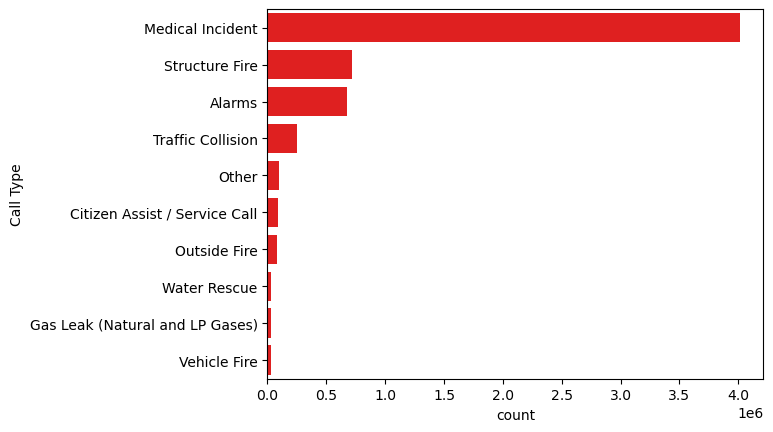

In [28]:
plotHorizBar(df=outcome_vis, xcol="count", ycol="Call Type", colour="red")

**5) What zip codes accounted for most common calls and what type were they?**

1. Filter out by Call Type
2. Group them by Call Type and Zipcode of Incident
3. Count them and display in descending order

In [29]:
( new_fire_df
     .
 
)

+----------------+-------------------+------+
|Call Type       |Zipcode of Incident|count |
+----------------+-------------------+------+
|Medical Incident|94102              |582264|
|Medical Incident|94103              |538180|
|Medical Incident|94109              |347426|
|Medical Incident|94110              |346086|
|Medical Incident|94124              |206334|
|Medical Incident|94112              |194948|
|Medical Incident|94115              |166438|
|Medical Incident|94107              |147324|
|Medical Incident|94122              |144526|
|Medical Incident|94133              |135291|
|Medical Incident|94117              |124388|
|Medical Incident|94114              |116025|
|Medical Incident|94134              |114919|
|Medical Incident|94118              |109054|
|Medical Incident|94121              |102458|
|Medical Incident|94116              |89414 |
|Medical Incident|94132              |87845 |
|Medical Incident|94105              |81881 |
|Alarms          |94102           

**6) What neighbourhoods are in the two top zip codes from the listing in the previous question?**

Probably these two zip codes are somehow related to contested neighbourhood with high reported crimes.

In [30]:
( new_fire_df
     .
 
)

+------------------------------------+-------------------+
|Neighborhooods - Analysis Boundaries|Zipcode of Incident|
+------------------------------------+-------------------+
|Financial District/South Beach      |94102              |
|South of Market                     |94102              |
|Mission Bay                         |94103              |
|Nob Hill                            |94102              |
|Castro/Upper Market                 |94103              |
|Hayes Valley                        |94102              |
|Tenderloin                          |94103              |
|Western Addition                    |94102              |
|Potrero Hill                        |94103              |
|Mission                             |94103              |
|Hayes Valley                        |94103              |
|Tenderloin                          |94102              |
|South of Market                     |94103              |
|Financial District/South Beach      |94103             

# Additional exercise

Using the given dataset, write down code to answer the following questions:

1. What was the sum of all calls, average, min and max of the response times for calls (from the moment call is received till response is acknowledged and unit is on route)?

    Hint: Use the functions sum(), avg(), min() and max()

2. How many distinct years of data is in the CSV file?

    Hint: Use the year() SQL Spark function off the timestamp of the Call Date column

3. What week of the year in 2017 had the most fire calls?

    Hint: Use the weekofyear() SQL Spark function off the timestamp of the Call Date column
    
Furthermore, create some visualizations to better understand the results obtained.

# References

* Learning Spark - Lightning-Fast Data Analytics, 2nd Ed. J. Damji, B. Wenig, T. Das, and D. Lee. O'Reilly, 2020
* https://spark.apache.org/docs/latest
* https://docs.python.org/3/


* https://data.sfgov.org/Public-Safety/Fire-Department-Calls-for-Service/nuek-vuh3
